In [79]:
import string
# read in data, remove punctuation and make all lower case
def read_words(filename):
    words = []
    translator = str.maketrans('', '', string.punctuation)
    scount = 0
    longest = 0
    w_freq = []
    with open(filename, encoding="utf8") as f:
        for s in f:
            scount += 1
            if scount == 10000:
                break
            clean_s = s.translate(translator).lower()
            words.append(clean_s.split())

            # keep track of longest sentence
            if len(s) > longest:
                 longest = len(s)
    return words, longest

In [80]:
# create dict that returns the index of onehot encoding for a word (and other way around)
# also create a frequency dict + set size, usuable for negative sampling
# import numpy as np

# def get_onehot_dicts(corpus):
#     # create one set of all unique words
#     flat_corpus = [w for s in corpus for w in s]
#     corpus_set = set(flat_corpus)
#     w_to_i = {}
#     i_to_w = {}
#     w_freq = []
#     num_words = len(corpus_set)
#     for i, w in enumerate(corpus_set):
#         # all indices + 1 to use zero padding later
#         w_to_i[w] = i + 1
#         i_to_w[i + 1] = w
#         freq = flat_corpus.count(w)**0.75
#         w_freq.append([i, freq])
#     return w_to_i, i_to_w, np.array(w_freq), num_words+1

In [82]:
import numpy as np
from collections import defaultdict
def get_onehot_dicts(corpus):
    # create one set of all unique words
    flat_corpus = [w for s in corpus for w in s]
    corpus_set = set(flat_corpus)
    w_to_i = defaultdict(int)
    i_to_w = defaultdict(lambda: '<unk>')
    w_freq = {}
    for i, w in enumerate(corpus_set):
        freq = flat_corpus.count(w)**0.75
        w_freq[w] = freq
    sorted_corp = sorted(corpus_set, key=lambda x: w_freq[x], reverse=True)

    for i, w in enumerate(sorted_corp[:500]):
        w_to_i[w] = i+1
        i_to_w[i+1] = w
    num_words = len(w_to_i)

    return w_to_i, i_to_w, np.array(w_freq), num_words+1

In [83]:
l1_corpus, longest1 = read_words('hansards/training.en')
l2_corpus, longest2 = read_words('hansards/training.fr')
# l1_corpus, longest1 = read_words('wa/test.en')
# l2_corpus, longest2 = read_words('wa/test.fr')

print('corpus created')
import time
start_time = time.time()
w_to_i1, i_to_w1, w_freq1, num_words1 = get_onehot_dicts(l1_corpus)
print('lang.1 done')
w_to_i2, i_to_w2, w_freq2, num_words2 = get_onehot_dicts(l2_corpus)
print(time.time()-start_time)


corpus created
lang.1 done
61.90531253814697


In [84]:
print(len(l1_corpus))
print(num_words1)
print(num_words2)

9999
501
501


In [85]:
# save w_to_i and i_to_w to files
import dill

with open('w2i_en_embedalign.pkl', 'wb') as f:
    dill.dump(w_to_i1, f)
    
with open('i2w_en_embedalign.pkl', 'wb') as f:
    dill.dump(i_to_w1, f)
    
with open('w2i_fr_embedalign.pkl', 'wb') as f:
    dill.dump(w_to_i2, f)
    
with open('i2w_fr_embedalign.pkl', 'wb') as f:
    dill.dump(i_to_w2, f)

In [86]:
# transform corpus to lists of ints
import torch

# convert to indexes and pad
l1_corpus_i = torch.LongTensor([[0] * (longest1-len(sentence)) + [w_to_i1[word] for word in sentence] for sentence in l1_corpus])
l2_corpus_i = torch.LongTensor([[0] *(longest2-len(sentence)) + [w_to_i2[word] for word in sentence] for sentence in l2_corpus])

del l1_corpus
del l2_corpus

In [87]:
import torch.nn as nn
import torch.distributions as dist
import torch.utils.data
from torch.utils.data import sampler
from torch.distributions import kl
class embed_align(nn.Module):
    def __init__(self, vocab_size1, vocab_size2, emb_dimension):
        super(embed_align, self).__init__()
        self.emb_dimension = emb_dimension

        self.embedding = nn.Embedding(vocab_size1, emb_dimension, padding_idx = 0)
        self.BiLSTM = nn.LSTM(emb_dimension, emb_dimension, bidirectional=True, batch_first=True)
        
        self.affine1_mu = nn.Linear(emb_dimension, emb_dimension)
        self.affine2_mu = nn.Linear(emb_dimension, emb_dimension)
        
        self.affine1_sig = nn.Linear(emb_dimension, emb_dimension)
        self.affine2_sig = nn.Linear(emb_dimension, emb_dimension)
        
        self.affine1_L1 = nn.Linear(emb_dimension, emb_dimension)
        self.affine2_L1 = nn.Linear(emb_dimension, vocab_size1)
        self.affine1_L2 = nn.Linear(emb_dimension, emb_dimension)
        self.affine2_L2 = nn.Linear(emb_dimension, vocab_size2)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.log_softmax = nn.Softmax(dim=0)
        
    def forward(self, sentence1, sentence2, use_cuda=False):
        # sentence1 & sentence2 are (batches of) list of all ints in a sentence
        # encoder
        sen1_emb = self.embedding(sentence1)
        if len(sen1_emb.shape) == 2: # not a batch
            sen1_emb = sen1_emb.unsqueeze(0)
        h, _ = self.BiLSTM(sen1_emb)
        h1, h2 = torch.split(h, split_size_or_sections=self.emb_dimension, dim =2)
        h = h1 + h2
        mu = self.affine2_mu(self.relu(self.affine1_mu(h)))
        sig = self.relu(self.affine2_sig(self.relu(self.affine1_sig(h))))
        
        sample_norm = dist.multivariate_normal.MultivariateNormal(torch.zeros(self.emb_dimension), torch.eye(self.emb_dimension))
        e = sample_norm.sample()
        if use_cuda:
            z = mu + e.cuda() * sig
        else:
            z = mu + e * sig
    
        # likelihood language 1
        dist_1 = self.log_softmax(self.affine2_L1(self.relu(self.affine1_L1(z))))
        # sum over batch
        sum_1 = torch.sum(dist_1, dim=0)
        likelihood_1 = torch.mean(sum_1, dim=1)
        total_likelihood1 = 0
        sen_len = 0
        for i, likelihood in enumerate(likelihood_1):
            # no batches:
            if len(sentence1) == longest1:
                if sentence1[i].item() == 0:
                    continue
                total_likelihood1 += likelihood
                sen_len +=1
            else:
                for j in range(len(sentence1)):
                    if sentence1[j][i].item() == 0:
                        continue
                    total_likelihood1 += likelihood
                sen_len +=1
        likelihood1 = total_likelihood1/sen_len
        
        # likelihood language 2
        dist_2 = self.log_softmax(self.affine2_L2(self.relu(self.affine1_L2(z))))
        sum_2 = torch.sum(dist_2, dim=0)
        likelihood_2 = torch.mean(sum_2, dim=1)
        total_likelihood2 = 0
        sen_len = 0
        for i, likelihood in enumerate(likelihood_2):
            # no batches:
            if len(sentence1) == longest1:
                if sentence1[i].item() == 0:
                    continue
                total_likelihood2 += likelihood
                sen_len +=1
            else:
                for j in range(len(sentence1)):
                    if sentence1[j][i].item() == 0:
                        continue
                    total_likelihood2 += likelihood
                sen_len +=1
        likelihood2 = total_likelihood2/sen_len
        
        # KL
        # to prevent log returning infinity
        sig = sig+1e-8
        KL =  -0.5 * torch.sum(1 + torch.log(sig) - mu.pow(2) - sig)
        return - ((likelihood1 + likelihood2) - KL)
        
        

13527233.0
4.4190514087677
1232119.125
424.34365224838257
1231978.375
433.36893010139465
1231891.75
450.58455634117126
1231825.625
442.19394874572754


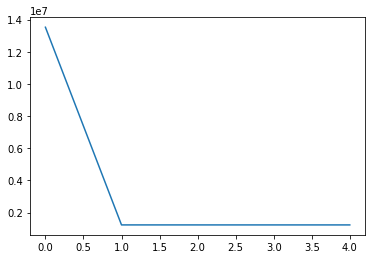

In [95]:
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import gc

gc.collect()

start_time = time.time()

use_cuda = torch.cuda.is_available()

ea_model = embed_align(num_words1, num_words2, 100)

if use_cuda:
    ea_model.cuda()

optimizer = torch.optim.Adam(ea_model.parameters(), lr=0.01)
ea_model.train()
loss_progress = []
iter_time = time.time()


total_data = torch.utils.data.TensorDataset(l1_corpus_i, l2_corpus_i)
dataloader = DataLoader(total_data, batch_size=20)
for i, batch in enumerate(dataloader):
    batch_l1 = batch[0]
    batch_l2 = batch[1]
    optimizer.zero_grad()

    if use_cuda:    
        loss = ea_model.forward(batch_l1.cuda(), batch_l2.cuda(), use_cuda=True)
    else:
        loss = ea_model.forward(batch_l1, batch_l2)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        loss_progress.append(loss.item())  
        print(loss_progress[-1])
        print(time.time()-iter_time)
        iter_time = time.time()
    
plt.plot(loss_progress)
plt.show()

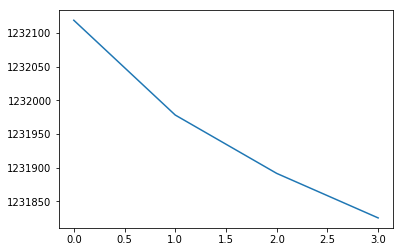

In [96]:
plt.plot(loss_progress[1:]) # without the initial loss

In [ ]:
torch.save(ea_model, 'embedalign.pt')